# Lab 5: Spam Detection

**Deadline**: Monday, Mar 14, 5:00 PM

**Late Penalty**: Any work that is submitted between 0 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Hossein Yousefi <hossein.yousefi@mail.utoronto.ca>

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link:https://colab.research.google.com/drive/11OOmh8l0eHUHHARaRVWcU2sYgBCZMQwy#scrollTo=HgfNOUaPa9z8

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [4]:
''' Answer: label and example of spam and non-spam'''
# From the data, we can see that the label for spam is "spam", and the label for non-spam is "ham"
found_ham, found_spam = False, False
for line in open('/content/drive/Othercomputers/my_mac_air/AI/aps360_labs/data/smsspamcollection/SMSSpamCollection'):
    label_and_text = line.split("\t")
    label = label_and_text[0]
    text = label_and_text[1]
    if label == 'ham' and found_ham == False:
        print("Non-spam example: {}".format(text))
        found_ham = True
    if label == "spam" and found_spam == False:
        print("Spam example: {}".format(text))
        found_spam = True
    if found_ham and found_spam:
        break

Non-spam example: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Spam example: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [5]:
''' Answer: Count the number of spam and non-spam messages'''
num_spam, num_ham = 0, 0
for line in open('/content/drive/Othercomputers/my_mac_air/AI/aps360_labs/data/smsspamcollection/SMSSpamCollection'):
    label_and_text = line.split("\t")
    label = label_and_text[0]
    if label == 'spam':
        num_spam += 1
    elif label == 'ham':
        num_ham += 1

print("Number of spam and non-spam messages are {} and {}".format(num_spam, num_ham))

Number of spam and non-spam messages are 747 and 4827


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

In [6]:
''' Answer: advantage and disadvantage of modelling SMS text messages as a sequence of characters '''
#$ Advantages
# 1. There are much less character than words, thus the vocabulary is much smaller, require less memory to store and have faster inference with the embedding. 
# 2. Training result will not be biased by misspelled words.
#$ Disadvantages
# 1. There are more characters than words in the input, thus character-based RNN would have more inputs for one data sample, and would require more computation power.
# 2. Lower accuracy than word-based RNN because the meaning are associated with the word, not the character. The kernel have to be longer in order to remember the meaning of the characters.

' Answer: advantage and disadvantage of modelling SMS text messages as a sequence of characters '

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [7]:
import torchtext
#/ modified torchtext.data to torchtext.legacy.data in torchtext version 0.9.0

text_field = torchtext.legacy.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.legacy.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.legacy.data.TabularDataset("/content/drive/Othercomputers/my_mac_air/AI/aps360_labs/data/smsspamcollection/SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

print("dataset[0].label: {}".format(dataset[0].label))
print("dataset[0].sms: {}".format(dataset[0].sms))

train_data, valid_data, test_data = dataset.split(split_ratio=[0.6,0.2,0.2])

dataset[0].label: 0
dataset[0].sms: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [8]:
''' Answer: Why can't we use imbalanced data'''
# If the dataset is imbalanced, the model itself will bias twoward predict the most frequent label in order to achieve a high training accuracy.
# However, this training result is not representative towards a general case.
# To prevent such bias, we should have a balanced dataset

" Answer: Why can't we use imbalanced data"

In [9]:
# save the original training examples
old_train_examples = train_data.examples
# get all the spam messages in `train`
train_spam = []
for item in train_data.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times to make the sample balanced
train_data.examples = old_train_examples + train_spam * 6

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [10]:
text_field.build_vocab(train_data)
print(text_field.vocab.stoi)
print("--------------------------------------------------------------")
print(text_field.vocab.itos)

defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f5f2afbf9d0>>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, 'h': 13, '0': 14, 'd': 15, '.': 16, 'c': 17, 'm': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, '2': 25, 'b': 26, 'T': 27, '8': 28, 'k': 29, 'v': 30, 'E': 31, '5': 32, 'S': 33, 'C': 34, 'O': 35, 'I': 36, '4': 37, 'N': 38, '7': 39, 'x': 40, '3': 41, '6': 42, 'A': 43, 'R': 44, '!': 45, '9': 46, ',': 47, 'P': 48, 'W': 49, 'M': 50, 'H': 51, 'L': 52, 'U': 53, 'B': 54, 'D': 55, '/': 56, 'Y': 57, 'G': 58, 'F': 59, '?': 60, "'": 61, '£': 62, '-': 63, '&': 64, ':': 65, 'z': 66, 'V': 67, 'X': 68, 'K': 69, 'j': 70, '*': 71, ')': 72, 'J': 73, ';': 74, '+': 75, 'Q': 76, '"': 77, 'q': 78, '(': 79, '#': 80, '>': 81, '=': 82, '@': 83, 'Z': 84, 'ü': 85, '$': 86, 'Ü': 87, '%': 88, '_': 89, '[': 90, ']': 91, '‘': 92, '\x92': 93, '<': 94, '\x93': 95, '“': 96, '|': 97, '

In [11]:
''' Answer: Explain what the variables text_field.vocab.stoi and text_field.vocab.itos represent '''
# text_field.vocab.stoi: a dictionary that map each character to a numerical identifier (character to index)
# text_field.vocab.itos: a list of characters order by their stoi index order (index to charcter)

' Answer: Explain what the variables text_field.vocab.stoi and text_field.vocab.itos represent '

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

In [12]:
''' Answer: what tokens <unk> and <pad> represent'''
# <unk> represent unknown words, which are not in the vocabulary
# <pad> is used to increase the length of the SMS message by add paddings in order to make input sequences in a batch to have the same length

' Answer: what tokens <unk> and <pad> represent'

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [13]:
train_iter = torchtext.legacy.data.BucketIterator(train_data,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [14]:
count = 0
print("Batch NO")
for batch in train_iter:
    if count >= 10:
        break
    else:
        count += 1
        print("NO.{}: ".format(count))
        print("\tMax length of input sequence: {}".format(batch.sms[1][0]))
        sum = 0
        for message in range(0, len(batch.sms[1])):
            sum = sum + batch.sms[1][0] - batch.sms[1][message]
        print("\tNumber of <pad> is:", int(sum))

Batch NO
NO.1: 
	Max length of input sequence: 142
	Number of <pad> is: 32
NO.2: 
	Max length of input sequence: 23
	Number of <pad> is: 32
NO.3: 
	Max length of input sequence: 32
	Number of <pad> is: 7
NO.4: 
	Max length of input sequence: 158
	Number of <pad> is: 0
NO.5: 
	Max length of input sequence: 143
	Number of <pad> is: 0
NO.6: 
	Max length of input sequence: 140
	Number of <pad> is: 17
NO.7: 
	Max length of input sequence: 50
	Number of <pad> is: 12
NO.8: 
	Max length of input sequence: 70
	Number of <pad> is: 46
NO.9: 
	Max length of input sequence: 38
	Number of <pad> is: 7
NO.10: 
	Max length of input sequence: 143
	Number of <pad> is: 23


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [15]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [16]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes=2):
        super(RNN, self).__init__()
        self.name = "Spam detector"
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size # number of hidden layer
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Look up the embedding value
        x = self.emb[x]
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [17]:
def get_accuracy(model, data, batch_size):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    data_loader = torchtext.legacy.data.BucketIterator(data,
                                                batch_size=batch_size,
                                                sort_key=lambda x: len(x.sms), # to minimize padding
                                                sort_within_batch=True,        # sort within each batch
                                                repeat=False)                  # repeat the iterator for many epochs

    correct, total = 0, 0
    for message, labels in data_loader:
        output = model(message[0])
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [18]:
import matplotlib.pyplot as plt

In [19]:
def train_rnn_network(model, train, valid, batch_size, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, valid_losses, train_acc, valid_acc = [], [], [], []
    epochs = []
    train_loader = torchtext.legacy.data.BucketIterator(train,
                                                 batch_size=batch_size,
                                                 sort_key=lambda x: len(x.sms),
                                                 sort_within_batch=True,
                                                 repeat=False)
    valid_loader = torchtext.legacy.data.BucketIterator(valid,
                                                 batch_size=batch_size,
                                                 sort_key=lambda x: len(x.sms),
                                                 sort_within_batch=True,
                                                 repeat=False)
    
    for epoch in range(num_epochs):
        for message, labels in train_loader:
            optimizer.zero_grad()
            pred = model(message[0])
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        train_losses.append(float(loss))

        for message, labels in valid_loader:
            pred = model(message[0])
            loss = criterion(pred, labels)
        valid_losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train, batch_size))
        valid_acc.append(get_accuracy(model, valid, batch_size))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch + 1, loss, train_acc[-1], valid_acc[-1]))
        model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), "/content/drive/Othercomputers/my_mac_air/AI/aps360_labs/output_data/Lab5/" + model_path)

    # plotting
    plt.title("Training Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(train_losses, label="Train")
    plt.plot(valid_losses, label="Validation")
    plt.show()

    plt.title("Training Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.show()

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

In [20]:
# There are four parameters that I choose, which are hidden units, batch_size, num_epoches, and learning_rate

In [21]:
input_size = len(text_field.vocab.itos)
print(input_size)

113


Epoch 1; Loss 0.675449; Train Acc 0.523416; Val Acc 0.860090
Epoch 2; Loss 0.672168; Train Acc 0.551547; Val Acc 0.859193
Epoch 3; Loss 0.683694; Train Acc 0.676816; Val Acc 0.802691
Epoch 4; Loss 0.686581; Train Acc 0.705610; Val Acc 0.719283
Epoch 5; Loss 0.677938; Train Acc 0.718517; Val Acc 0.731839
Epoch 6; Loss 0.300440; Train Acc 0.804236; Val Acc 0.910314
Epoch 7; Loss 0.355585; Train Acc 0.889955; Val Acc 0.932735
Epoch 8; Loss 0.420898; Train Acc 0.914446; Val Acc 0.905830
Epoch 9; Loss 0.298913; Train Acc 0.908158; Val Acc 0.944395
Epoch 10; Loss 0.214324; Train Acc 0.898726; Val Acc 0.939013
Epoch 11; Loss 0.213922; Train Acc 0.934304; Val Acc 0.938117
Epoch 12; Loss 0.321273; Train Acc 0.919576; Val Acc 0.944395
Epoch 13; Loss 0.158448; Train Acc 0.910806; Val Acc 0.947982
Epoch 14; Loss 0.233205; Train Acc 0.942082; Val Acc 0.929148
Epoch 15; Loss 0.362664; Train Acc 0.945060; Val Acc 0.932735
Epoch 16; Loss 0.310774; Train Acc 0.936455; Val Acc 0.930942
Epoch 17; Loss 0.

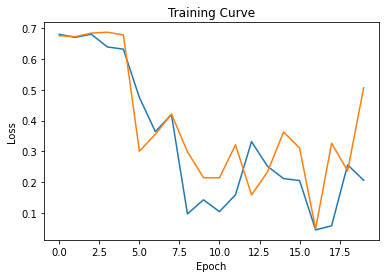

No handles with labels found to put in legend.


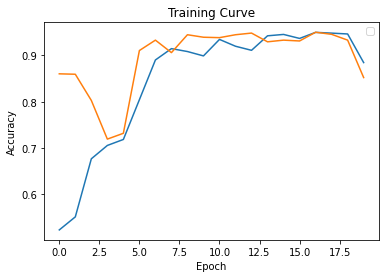

In [22]:
# 1. Hidden units = 100, batch_size = 64, num_epoches = 20 and lr = 5e-5
model = RNN(input_size, 100)  
train_rnn_network(model, train_data, valid_data, batch_size=64, num_epochs=20, learning_rate=5e-5)

Epoch 1; Loss 0.586423; Train Acc 0.777263; Val Acc 0.837668
Epoch 2; Loss 0.532362; Train Acc 0.778421; Val Acc 0.862780
Epoch 3; Loss 0.176732; Train Acc 0.866457; Val Acc 0.913004
Epoch 4; Loss 0.156704; Train Acc 0.912792; Val Acc 0.951570
Epoch 5; Loss 0.215885; Train Acc 0.878041; Val Acc 0.927354
Epoch 6; Loss 0.151232; Train Acc 0.925534; Val Acc 0.956054
Epoch 7; Loss 0.169675; Train Acc 0.919742; Val Acc 0.957848
Epoch 8; Loss 0.525792; Train Acc 0.916598; Val Acc 0.856502
Epoch 9; Loss 0.135145; Train Acc 0.919576; Val Acc 0.968610
Epoch 10; Loss 0.114015; Train Acc 0.915605; Val Acc 0.966816
Epoch 11; Loss 0.097011; Train Acc 0.925203; Val Acc 0.970404
Epoch 12; Loss 0.151332; Train Acc 0.931822; Val Acc 0.969507
Epoch 13; Loss 0.043279; Train Acc 0.916101; Val Acc 0.979372
Epoch 14; Loss 0.108025; Train Acc 0.939930; Val Acc 0.968610
Epoch 15; Loss 0.129554; Train Acc 0.938772; Val Acc 0.971300
Epoch 16; Loss 0.112293; Train Acc 0.934139; Val Acc 0.972197
Epoch 17; Loss 0.

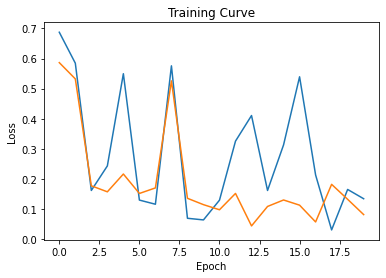

No handles with labels found to put in legend.


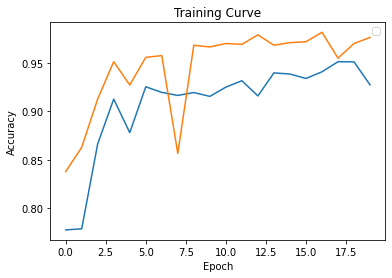

In [26]:
# 2. Hidden units = 100, batch_size = 64, num_epoches = 20 and lr = 5e-4
# Increase the learning_rate compared to the last model from lr = 5e-5 to lr = 5e-4
model = RNN(input_size, 100)   
train_rnn_network(model, train_data, valid_data, batch_size=64, num_epochs=20, learning_rate=5e-4)
# Since the parameter lr = 5e-4 works better, I will use lr = 5e-4 afterwards

Epoch 1; Loss 0.396269; Train Acc 0.781731; Val Acc 0.905830
Epoch 2; Loss 0.071405; Train Acc 0.905180; Val Acc 0.955157
Epoch 3; Loss 0.170840; Train Acc 0.901539; Val Acc 0.949776
Epoch 4; Loss 0.146436; Train Acc 0.786033; Val Acc 0.929148
Epoch 5; Loss 0.992690; Train Acc 0.795135; Val Acc 0.649327
Epoch 6; Loss 0.671257; Train Acc 0.711236; Val Acc 0.453812
Epoch 7; Loss 1.997282; Train Acc 0.664240; Val Acc 0.412556
Epoch 8; Loss 0.345816; Train Acc 0.923217; Val Acc 0.913901
Epoch 9; Loss 0.653349; Train Acc 0.748800; Val Acc 0.512108
Epoch 10; Loss 0.180802; Train Acc 0.918583; Val Acc 0.934529
Epoch 11; Loss 0.267436; Train Acc 0.922886; Val Acc 0.945291
Epoch 12; Loss 0.139940; Train Acc 0.922721; Val Acc 0.974888
Epoch 13; Loss 0.795916; Train Acc 0.709581; Val Acc 0.728251
Epoch 14; Loss 0.277411; Train Acc 0.751117; Val Acc 0.885202
Epoch 15; Loss 0.065878; Train Acc 0.764024; Val Acc 0.772197
Epoch 16; Loss 0.329903; Train Acc 0.843786; Val Acc 0.863677
Epoch 17; Loss 0.

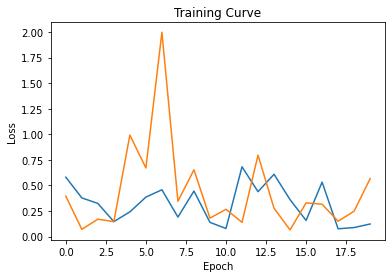

No handles with labels found to put in legend.


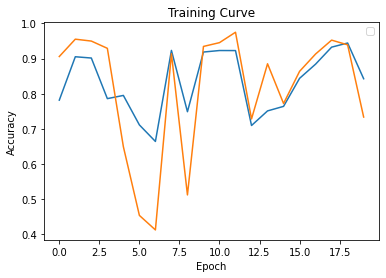

In [27]:
# 3. Hidden units = 100, batch_size = 32, num_epoches = 20 and lr = 5e-4
# Decrease the batch_size compared to previous model
model = RNN(input_size, 100)   
train_rnn_network(model, train_data, valid_data, batch_size=32, num_epochs=20, learning_rate=5e-4)
# Since batch_size=32 doesn't work as well as batch_size=64, I will return to batch_size=64

Epoch 1; Loss 0.687359; Train Acc 0.687241; Val Acc 0.786547
Epoch 2; Loss 0.701028; Train Acc 0.628496; Val Acc 0.225112
Epoch 3; Loss 0.353841; Train Acc 0.792487; Val Acc 0.884305
Epoch 4; Loss 0.357854; Train Acc 0.837001; Val Acc 0.881614
Epoch 5; Loss 0.230825; Train Acc 0.888962; Val Acc 0.878924
Epoch 6; Loss 0.263767; Train Acc 0.915936; Val Acc 0.902242
Epoch 7; Loss 0.211083; Train Acc 0.809697; Val Acc 0.896861
Epoch 8; Loss 0.250833; Train Acc 0.848420; Val Acc 0.901345
Epoch 9; Loss 0.360798; Train Acc 0.923051; Val Acc 0.880717
Epoch 10; Loss 1.140820; Train Acc 0.921893; Val Acc 0.879821
Epoch 11; Loss 0.226730; Train Acc 0.906503; Val Acc 0.921973
Epoch 12; Loss 0.688593; Train Acc 0.739864; Val Acc 0.531839
Epoch 13; Loss 0.722191; Train Acc 0.829886; Val Acc 0.820628
Epoch 14; Loss 0.093041; Train Acc 0.887308; Val Acc 0.912108
Epoch 15; Loss 0.130674; Train Acc 0.919576; Val Acc 0.916592
Epoch 16; Loss 1.082565; Train Acc 0.931987; Val Acc 0.914798
Epoch 17; Loss 0.

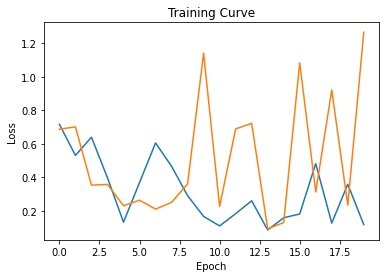

No handles with labels found to put in legend.


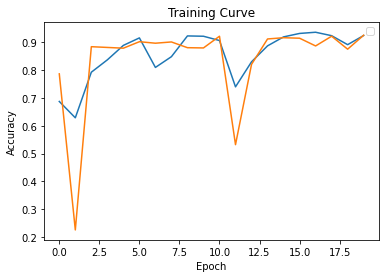

In [29]:
# 4. Hidden units = 200, batch_size = 64, num_epoches = 20 and lr = 5e-4
# Increase the number of hidden layers
model = RNN(input_size, 200)   
train_rnn_network(model, train_data, valid_data, batch_size=128, num_epochs=20, learning_rate=5e-4)
# Since hidden_unit=200 doesn't work as well as hidden_unit=100, I will return to hidden_unit=100 
# After 4 tries, the best model is NO.2

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [44]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.legacy.data.Dataset(
    [e for e in valid_data.examples if e.label == 1],
    valid_data.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.legacy.data.Dataset(
    [e for e in valid_data.examples if e.label == 0],
    valid_data.fields)

# import my model and parameter
best_model = RNN(input_size, 100)
best_model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format("Spam detector", 64, 5e-4, 19)
state = torch.load("/content/drive/Othercomputers/my_mac_air/AI/aps360_labs/output_data/Lab5/" + best_model_path)
best_model.load_state_dict(state)

false_positive_rate = 1 - get_accuracy(best_model, valid_nospam, 32)
false_negative_rate = 1 - get_accuracy(best_model, valid_spam, 32)

print("False positive rate for valid_data:", false_positive_rate)
print("false negative rate for valid_data:", false_negative_rate) 

False positive rate for valid_data: 0.004069175991861629
false negative rate for valid_data: 0.16666666666666663


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

In [35]:
# False positive and false negative corresponds to different region in the confusion matrix. 
# False positive are the predictions that are wrong. False negative are the correct prediction that the model doesn't predicted.
# Taking the spam message as an example.
# False positive indicates a spam messageis classified as a non-spam. The user would have annoying messages that should be included.
# False negative indicates a non-spam message is classified as a spam. The user would miss some messages that he don't want to spam.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [43]:
best_model = RNN(input_size, 100)
best_model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format("Spam detector", 64, 5e-4, 19)
state = torch.load("/content/drive/Othercomputers/my_mac_air/AI/aps360_labs/output_data/Lab5/" + best_model_path)
best_model.load_state_dict(state)

test_accuracy = get_accuracy(best_model, test_data, 64)
print("Test accuracy:", test_accuracy)

Test accuracy: 0.9703770197486535


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [45]:
# Create a Dataset of only spam test examples
test_spam = torchtext.legacy.data.Dataset(
    [e for e in test_data.examples if e.label == 1],
    test_data.fields)
# Create a Dataset of only non-spam test examples
test_nospam = torchtext.legacy.data.Dataset(
    [e for e in test_data.examples if e.label == 0],
    test_data.fields)

best_model = RNN(input_size, 100)
best_model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format("Spam detector", 64, 5e-4, 19)
state = torch.load("/content/drive/Othercomputers/my_mac_air/AI/aps360_labs/output_data/Lab5/" + best_model_path)
best_model.load_state_dict(state)

false_positive_rate = 1 - get_accuracy(model, test_nospam, 32)
false_negative_rate = 1 - get_accuracy(model, test_spam, 32)

print("False positive rate for test_data:", false_positive_rate)
print("False negative rate for test_data:", false_negative_rate)

False positive rate for test_data: 0.03161222339304526
False negative rate for test_data: 0.2727272727272727


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [47]:
msg = "machine learning is sooo cool!"

In [52]:
# print(text_field.vocab.stoi)
msg_list = []
for index in range(0, len(msg)):
    msg_list.append(text_field.vocab.stoi[msg[index]])

tset_message = torch.LongTensor([msg_list])
pred = best_model(tset_message)
a = pred[0][1]

# Using softmax
prob_of_spam = np.exp(float(pred[0][1])) / (np.exp(float(pred[0][0])) + np.exp(float(pred[0][1])))
print("Probability of spam:", prob_of_spam)

Probability of spam: 0.2524132959478053


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

In [ ]:
# I would say that detecting spam is not a simple task.
# A baseline model for spam detection could be Bayes Spam Filter.
# I read about Bayes Spam Filter from the following link
# https://towardsdatascience.com/na%C3%AFve-bayes-spam-filter-from-scratch-12970ad3dae7, 
# What this algorithm do is finding the probability that each word is spam, and then multiply these 
# probabilities together to get the overall email spam metric to be used in classification.
# All possiblilities of single word are multiplied together to give the overall probability that the
# email is spam. If this probability is over the 'spam threshold' of 0.5, the email is classified as 
# a spam email.

# An obvious defect in this algorithm is it separate the correlation between words. Take one word 
# at a time disallow the spam detector to learn the symantic, expression, and intension of languages, 
# thus, it would produce a valid result compared with machine learning.


